# Instrumental Variables

A/B tests are the golden standard of causal inference because they allow us to make valid causal statements with minimal assumptions, thanks to **randomization**. In fact, by randomly assigning a **treatment** (a drug, ad, product, ...), we are able to compare the **outcome** of interest (a disease, firm revenue, customer satisfaction, ...) across **subjects** (patients, users, customers, ...) and attribute the average difference in outcomes to the causal effect of the treatment.

However, in many settings, it is **not possible to randomize** the treatment, for either ethical or practical reasons. One common online setting is the case of a paying feature that we cannot force onto customers, as in the case of subscriptions or premium memberships. Other settings include features for which we cannot discriminate customers, like insurance contracts, or features that are so deeply hard-coded that setting up an experiment might not be worth the effort. Can we still do valid causal inference in those settings?

The answer is yes, thanks to **instrumental variables** and the corresponding experimental design called **encouragement design**. In many of the settings mentioned above, we cannot randomly *assign* treatment, but we can *encourage* some customers to take it. For example, we can offer a subscription discount or we can change the order in which some options are presented. While customers retain the ultimate word on taking the treatment, we are still able to estimate a causal treatment effect. Let's see how.

## Evaluating Subscriptions

In the rest of the article, we are going to use a toy example. Suppose you were an online company and you have a weekly **newsletter**. You would like to understand whether the newsletter is worth the effort and whether it is actually successful in increasing **sales**. Unfortunately, you cannot run a standard A/B test since you cannot force customers to **subscribe** to the newsletter. Does it mean you cannot evaluate the newsletter? Not exactly. 

Let's assume we have also run an A/B test on a new **notification** on our mobile app that promotes the newsletter. A random sample of our customers has received the notification, while a random sample has not. Perhaps this A/B test was not related to the evaluation of the causal effect at all, as it sometimes happens in large companies. However, this is a great opportunity for a data scientist who was interested in understanding the impact of the newsletter on **sales**.

Let's first have a look at the data. For ea

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_notification_newsletter

In [3]:
dgp = dgp_notification_newsletter(n=10_000)
df = dgp.generate_data()
df.head()

,notification,subscription,spend
0,0,0,10.48
1,1,0,12.77
2,0,0,11.17
3,1,0,10.44
4,0,0,8.99


We have information on *10.000* customers, for whom we observe whether or not they received the `notification`, whether they `subscribed` and hw much they `spent`. For the rest of the article we will label these variables as follows:

- `notification`, the **treatment assignment**, *Z*
- `subscription`, the **treatment status**, *W*
- `spend`, the **outcome**, *Y*

A **naive approach** would be to compare the difference in `spend` between customers that `subscribed` and those who didn't. The corresponding causal object or *estimand* is 
 
$$
\tau_{W \to Y} = \mathbb{E} \Big[ \text{spend} \ | \ \text{subscribe} = 1 \Big] - \mathbb{E} \Big[ \text{spend} \ | \ \text{subscribe} = 0 \Big]
$$

Let's plot the values in a barplot.

In [4]:
def plot_group_comparison(df, x, y, title, xticks):
    fig, ax = plt.subplots()
    g = sns.barplot(data=df.sort_values([y, x]), x=x, y=y, ci=None, ax=ax)
    g.set(ylabel="", xlabel="")
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.set_xticklabels(xticks)
    diff = df.loc[df[x]==1, y].mean() - df.loc[df[x]==0, y].mean()
    plt.suptitle(title)
    plt.title(f"Difference: {diff:.2f}", fontsize=16, fontweight=None, y=0.95)

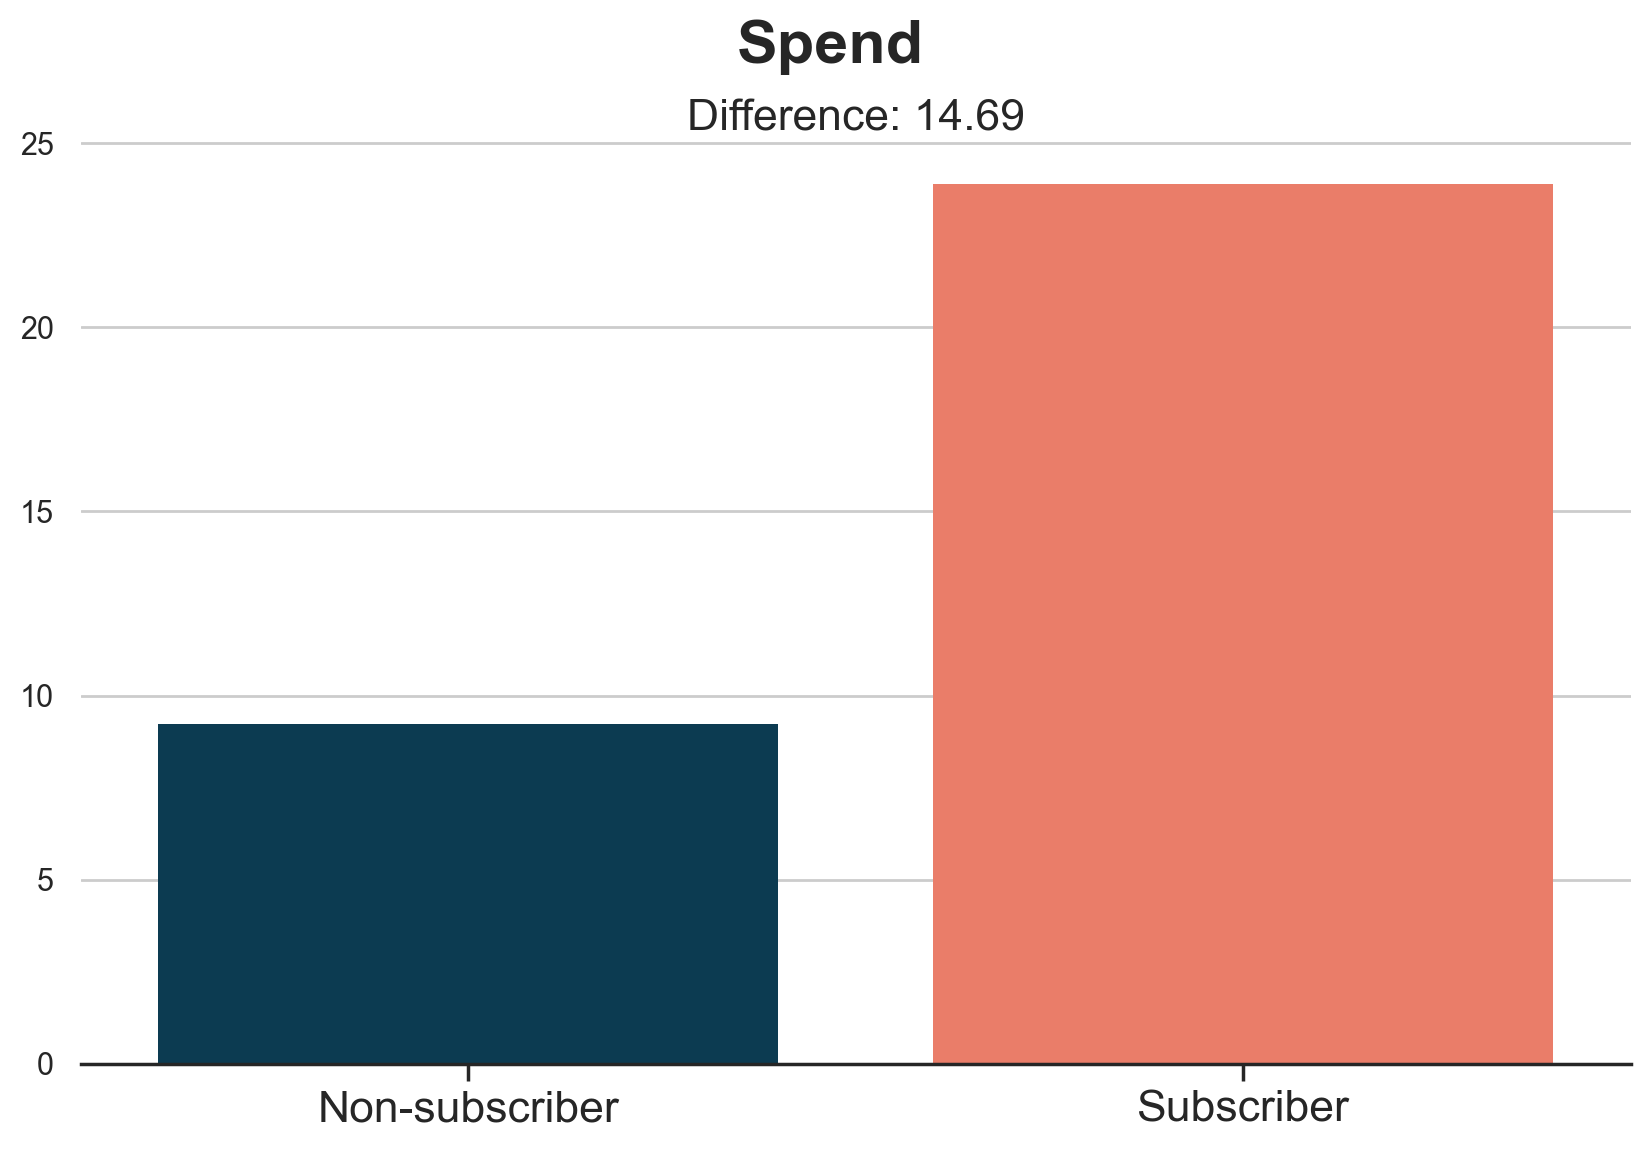

In [21]:
plot_group_comparison(df, x="subscription", y="spend", title="Spend", xticks=["Non-subscriber", "Subscriber"])

Subscribers spend much more money than non-subscribers. But is it a **causal** effect?

We can imagine that customers who are more active and more interested in our product will also be more interested in hearing news about it. For example, we can imagine that those that have more **budget** to spend, will also want to spend it better and subscribe to the newsletter. 

We can represent the relationship between the variables in the following Directed Acyclic Graph (DAG). If you never heard of DAGs, I recommend reading my [introductory article](https://towardsdatascience.com/b63dc69e3d8c)) first.

https://towardsdatascience.com/b63dc69e3d8c

In the plot, we represent variables with circles and causal relationships with arrows.

```mermaid
flowchart LR
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;

U((budget))
X((subscription))
Y((spend))

U --> X
U --> Y
X --> Y

class X,Y included;
class U excluded;
```

Technically speaking, customer's **budget** is an unobservable confounder that opens a spurious path between our treatment, the `subscription`, and the outcome, customers' `spend`. Because of it, we cannot interpret the difference-in-means estimate as causal.

What can we do?

## Experimental Design

Unfortunately, we cannot run an A/B test because we cannot force people to subscribe to the newsletter. However, we can **encourage** people to subscribe. For example, we can send them an **email** to remind them. This setting is called an encouragement design.

![img](fig/instrumental_variables1.png)

With the encouragement, the data generating process can be represented with the following DAG.

```mermaid
flowchart LR
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;

U((budget))
Z((notification))
X((subscription))
Y((buy))

U --> X
U --> Y
Z --> X
X --> Y

class Z,X,Y included;
class U excluded;
```

Strictly speaking, now we have closed the open path between `subscription` and `buy`. Therefore, we can not estimate the causal effect of the subscription on the probability of making a sale.

Was the `notification` effective? Thanks to randomization, we can attribute the average difference in `spend` between people that received the `notification` and people that did not, to the treatment itself.

$$
\tau_{Z \to Y} = \mathbb{E} \Big[ \text{spend} \ | \ \text{notification} = 1 \Big] - \mathbb{E} \Big[ \text{spend} \ | \ \text{notification} = 0 \Big]
$$

If we compute this difference in means, it looks like the notification has increase `spend` by roughly *1€* per customer.

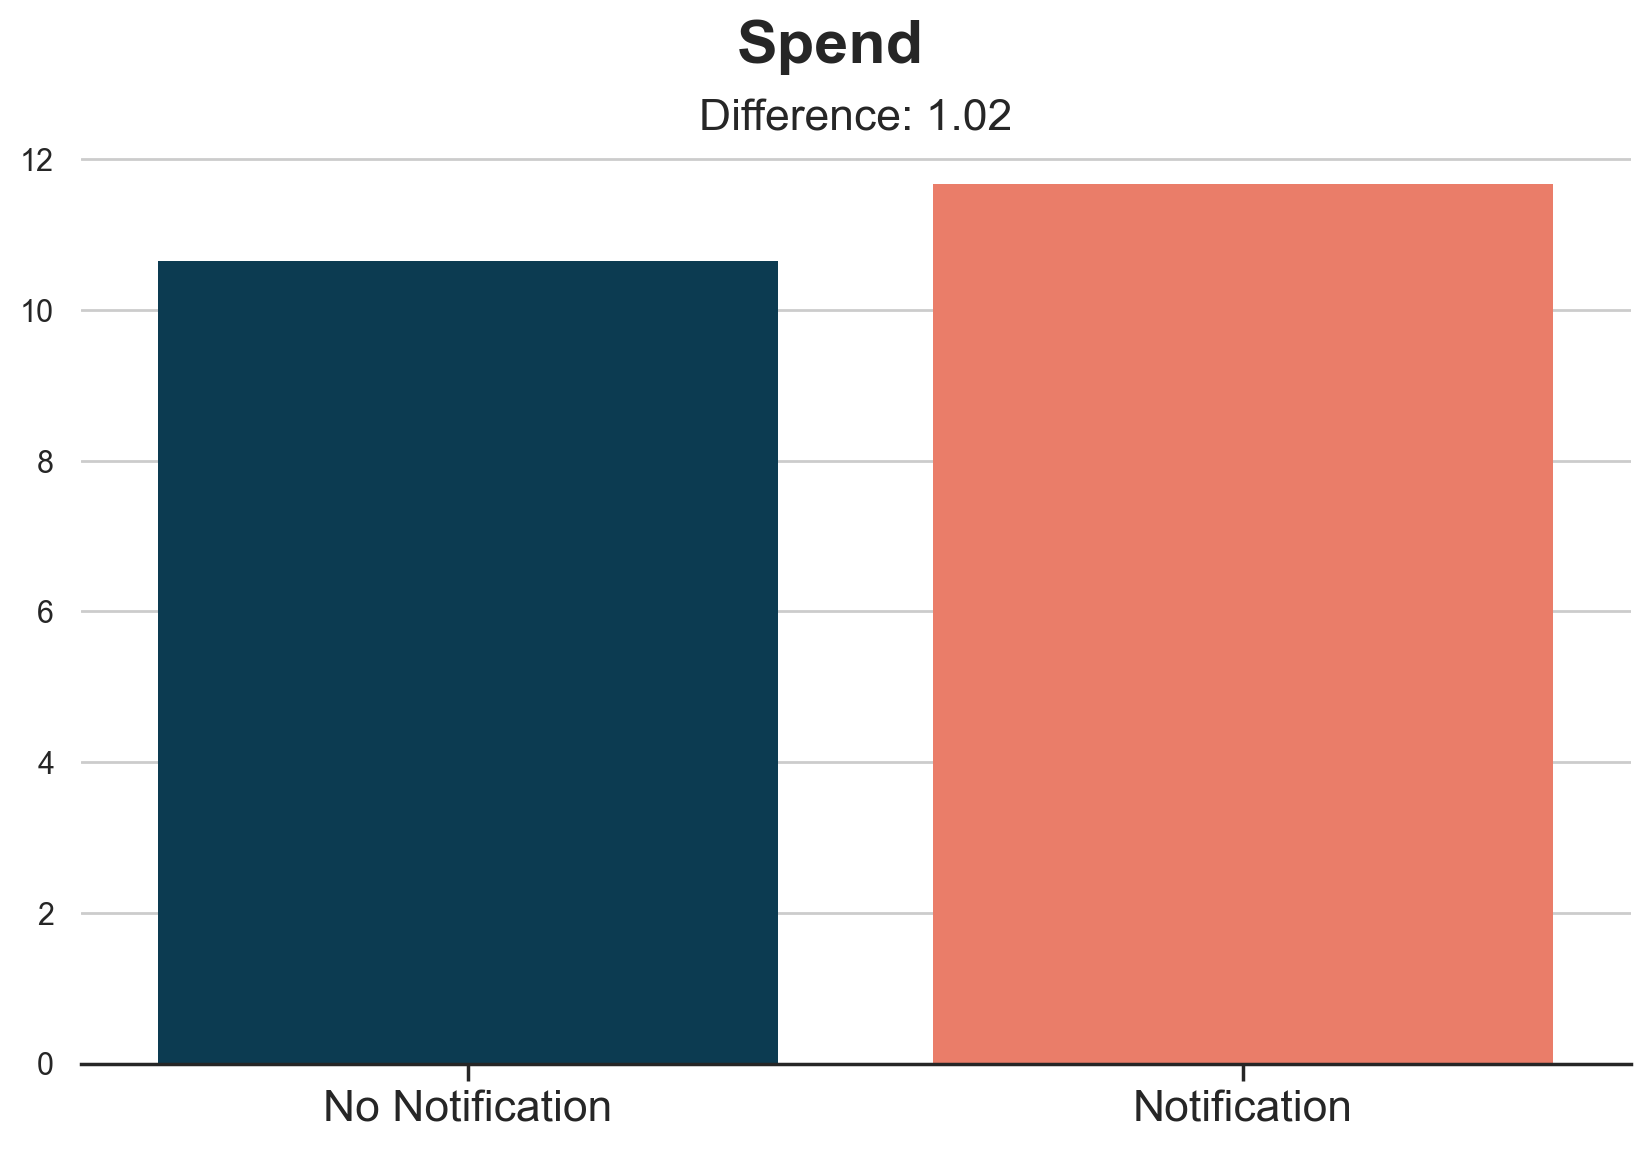

In [10]:
plot_group_comparison(df, x="notification", y="spend", title="Spend", xticks=["No Notification", "Notification"])

However, the effect of the `notification` on `spend` is not what we are interested in. We would rather know the effect of the `subscription` on `spend`. In fact, not all people that receive the email subscribe to the newletter. And viceversa, some people subscribe to the newsletter even without the notification. 

This means that the effect that we have just computed is **diluted** by the fact that some people do not comply with our incentive, the `notification`. We have to attribute it *only* to the customers that changed their mind because of the newsletter. How many are these customers?

Let's compute the probability of `subscription`, by treatment group. 

$$
\tau_{Z \to W} = \mathbb{E} \Big[ \text{subscription} \ | \ \text{notification} = 1 \Big] - \mathbb{E} \Big[ \text{subscription} \ | \ \text{notification} = 0 \Big]
$$

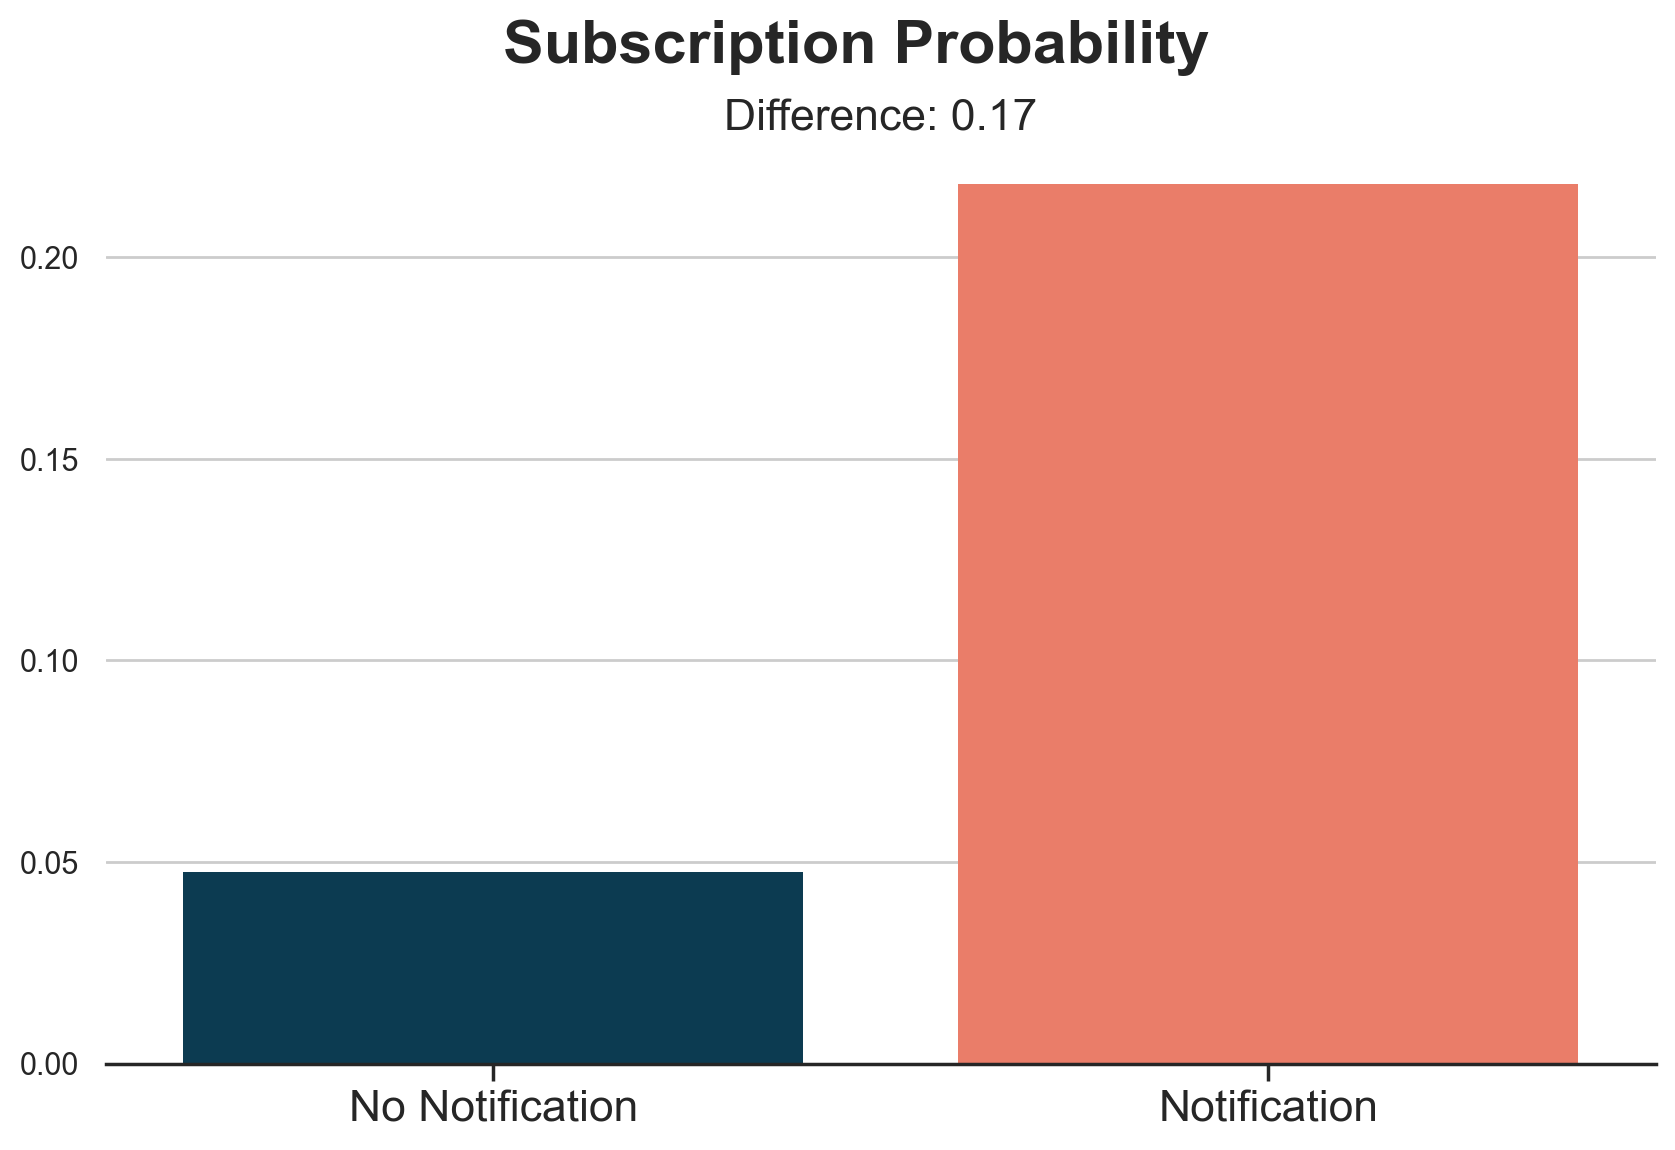

In [12]:
plot_group_comparison(df, x="notification", y="subscription", title="Subscription Probability", xticks=["No Notification", "Notification"])

Customers that received the `notification` have a *21%* higher `subscription` probability. In other words, it seems that the `notification` is able to make *21%* of our customers change their mind. From the control group, we learn that *38%* of them would have subscribed anyways, while the remaining *41%* we are unable to convince. 

Therefore, we should consider that only *21%* of customers are responsible the effect of the `notification` on `spend`, of 

In [19]:
from linearmodels.iv.model import IV2SLS as iv
model_iv = iv.from_formula("spend ~ 1 + [subscription ~ notification]", data=df).fit()
model_iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,10.371,0.0859,120.67,0.0000,10.202,10.539
subscription,5.9903,0.5436,11.020,0.0000,4.9249,7.0557


## Intuition

In this case, with a binary instrument, the `notification`, a binary treatment, the `subscription` decision, and a 50-50 assignment probability, we can get a very simple intuition of how instrumental variables work.

We have four groups of customers, depending on whether they received the notification or not, and wether they subscribed or not.

In [20]:
df.groupby(["notification", "subscription"]).agg(spend=("spend", "sum"), customers=("spend", "count")).iloc[::-1].T.round(0)

notification        1                0         
subscription        1        0       1        0
spend         25241.0  33147.0  6508.0  46765.0
customers      1091.0   3909.0   237.0   4763.0

![img](fig/instrumental_variables2.png)

Comparing treatment (`notification`) and control group, we see that the notification has generated an increase in `spend` of *2.7k€*. In order to recover the causal effect of interest, we just need to attribute the *2.7k€* incremental `spend` to the *800* customers that decided to `subscribe` because of the `notification`. The result is exactly *3.2€* per customer!

![img](fig/instrumental_variables3.png)

More generally, the IV estimate is given by the **ratio of two causal effects**: the effect of the instrument on the outcome, over the effect of the instrument on the endogenous variable.

$$
\tau_{IV} = \frac{\tau_{Z \to Y}}{\tau_{Z \to W}} = \frac{\mathbb{E} \Big[ \text{spend} \ | \ \text{notification} = 1 \Big] - \mathbb{E} \Big[ \text{spend} \ | \ \text{notification} = 0 \Big]}{\mathbb{E} \Big[ \text{subscription} \ | \ \text{notification} = 1 \Big] - \mathbb{E} \Big[ \text{subscription} \ | \ \text{notification} = 0 \Big]}
$$

which actually corresponds to a ratio of covariances!

$$
\tau_{IV} = \frac{\text{Cov} (Z, Y)}{\text{Cov} (Z, W)}
$$

## The Limits of IV

The main limit of instrumental variables in an experimental setting, as analyzed in this article, is that they estimate a very "special" causal effect. As we have seen in the previous section, we have to re-scale the total effect by the number of customers who decided to `subscribe` because of the `newsletter`. This means that we can estimate the effect only for those customers that we *complied* with our interventions. This set of customers is usually called **compliers** and the corresponding causal effect is sometimes called the **Local Average Treatment Effect (LATE)** or **Compliers Average Causal Effect (CACE)**.

We are unfortunately unable to say anything about customers who subscribed to the `newsletter` even without the `notification`, called the **always-takers**, and those that we couldn't convince with the `notification`, the **never-takers**.

Another limit of IV concerns its **assumptions**. In the last paragraph, we talked about three groups of customers, the compliers (our favorite one), always-takers, and never-takers. You might have noticed that this characterization implies the existence of a fourth group: the **defiers**. Those are the customers that would have `subscribed` to the newsletter if we had not received the `notification`. However, they changed their mind, *defying* the intent of the instrument. In general, we can represent the four groups in a simple *2x2* table as follows.

![img](fig/instrumental_variables4.png)

As you can imagine, we have to assume them away, otherwise our re-scaling would be wrong. In 

## Conclusion

In this article, we have explored multiple methods to evaluate uplift models. The **main challenge** is the unobservability of the variable of interest, the Individual Treatment Effects. Therefore, different methods try to evaluate uplift models either using other variables, using proxy outcomes, or approximating the effect of implied optimal policies.

It is hard to recommend using a single method since there is **no consensus** on which one performs best, neither from a theoretical nor from an empirical perspective. Loss functions that use R- and DR- elements tend to perform **consistently better**, but are also biased towards the corresponding learners. Understanding how these metrics work, however, can help in understanding their biases and limitations in order to make the most appropriate decisions depending on the specific scenario.

### References

- Spotify (2023), [Encouragement Designs and Instrumental Variables for A/B Testing](https://engineering.atspotify.com/2023/08/encouragement-designs-and-instrumental-variables-for-a-b-testing/)

- Ding (2023), [A First Course in Causal Inference](https://arxiv.org/abs/2305.18793).

### Related Articles

- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)

- [Understanding Omitted Variable Bias](https://towardsdatascience.com/344ac1477699)

- [Understanding The Frisch-Waugh-Lovell Theorem](https://towardsdatascience.com/59f801eb3299)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/instrumental_variables.ipynb